In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
import torch.nn.utils as nn_utils
from tqdm import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import NSF2
from gpzoo.utilities import rescale_spatial_coords, dims_autocorr, regularized_nmf, add_jitter, scanpy_sizefactors #init_softplus
import gpzoo.pri_experiment_utilities as putil
import squidpy as sq
import numpy as np
import time
import random
import scanpy as sc
import anndata as ad
from anndata import AnnData
from squidpy.gr import spatial_neighbors, spatial_autocorr
from sklearn.cluster import KMeans
from os import path

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
random.seed(256)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

root_path = '/engelhardt/home/pshrestha/vnngp'

In [3]:
dtp = "float32"
dpth = path.join(root_path, "data/")
mpth = path.join(root_path, "models/")
rpth = path.join(root_path, "results/")
pvisium_pth = path.join(rpth, "paper_visium/")
visium_pth = path.join(rpth, "visium/")
slideseq_pth = path.join(rpth, "slideseq/")

## Visium

In [4]:
X, Y = putil.load_visium()

In [5]:
Y.shape

(11925, 2688)

In [12]:
L = 10
max_iter = 1000

In [13]:
# Initialize with NMF
start = time.time()
factors, loadings = regularized_nmf(Y.T, L=L, max_iter = 1000, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=256)
end = time.time()
total_time = end - start

In [14]:
factors = torch.tensor(factors)
loadings = torch.tensor(loadings)

In [15]:
print(factors.shape)
print(loadings.shape)

torch.Size([2688, 10])
torch.Size([11925, 10])


In [16]:
nmf_visium_save_pth = path.join(visium_pth, f"nmf/nmf_factors_iter={max_iter}_rs=256_L={L}.pt")

In [17]:
torch.save({'factors': factors, 'loadings': loadings, 'time': total_time}, nmf_visium_save_pth)

## Slideseq

In [4]:
X, Y = putil.load_slideseq()

/engelhardt/home/pshrestha/anaconda3/envs/vnngp/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


In [7]:
Y.shape

(11925, 2688)

In [5]:
L = [10]
max_iter = 10000

In [6]:
# Initialize with NMF
#L = [5, 8, 10, 12, 15]
L = [10]
max_iter = 10000

for l in L:
    start = time.time()
    factors, loadings = regularized_nmf(Y.T, L=l, max_iter = max_iter, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=256)
    end = time.time()
    total_time = end - start

    factors = torch.tensor(factors)
    loadings = torch.tensor(loadings)

    nmf_slideseq_save_pth = path.join(slideseq_pth, f"nmf/nmf_factors_iter={max_iter}_rs=256_L={l}.pt")
    torch.save({'factors': factors, 'loadings': loadings, 'time': total_time}, nmf_slideseq_save_pth)
    print("Done")

Done


In [7]:
X = np.array(X)
Y = np.array(Y)
factors = np.array(factors)
moran_idx, moranI = putil.dims_autocorr(factors, X)

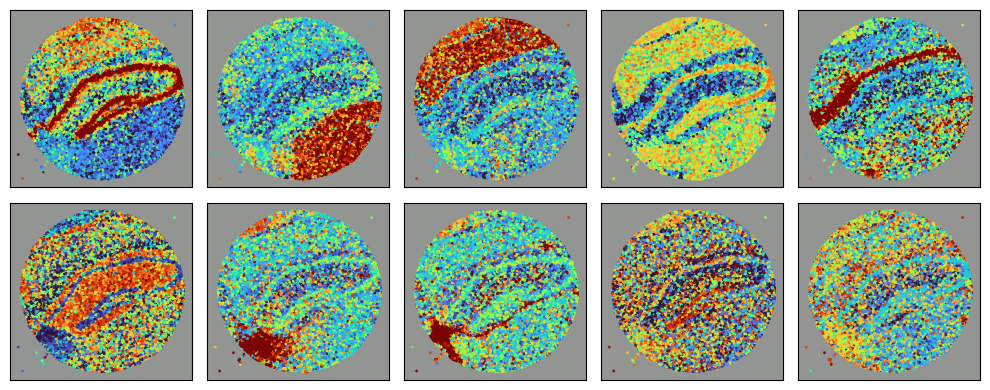

In [8]:
size=2
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
putil.plot_factors(factors.T, X, moran_idx=moran_idx, size=2, s=1.0, alpha=0.9, ax=axes)